In [47]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [48]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_hierarchical_prediction-V1_0_s_1024-20250223_140644.csv" # exalted-sweep-9
pred_file = "effnet_hierarchical_prediction-V1_0_s_1024-20250223_212824.csv" # fast-sweep-4
root_data_path = os.path.join("..", "data", ds_version)
data_path = os.path.join(root_data_path, "metadata")

In [49]:
pred = pd.DataFrame()

print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_label_pred"}, inplace=True)

quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_label_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]
pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

reading effnet_hierarchical_prediction-V1_0_s_1024-20250223_212824.csv


In [50]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [51]:
df = pred.join(
    annot[["image_id", "type_true", "quality_label_true", "quality_float_true", "train"]].set_index("image_id"), how="left")

In [52]:
df_test_type = df[~df.train]
df_test_type

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1001609044211988,3.144112,intermediate,0,0.998083,unpaved,0,unpaved,intermediate,3,False
1001729437616660,2.442628,good,0,0.994986,asphalt,0,paving_stones,intermediate,3,False
1003320543995770,1.175913,excellent,0,0.999399,asphalt,0,asphalt,good,2,False
1003492640340054,1.161310,excellent,0,0.996523,asphalt,0,asphalt,good,2,False
10036430943063472,3.251570,intermediate,0,0.999886,sett,0,sett,bad,4,False
...,...,...,...,...,...,...,...,...,...,...
989870525476597,2.365949,good,0,0.998537,asphalt,0,asphalt,good,2,False
992410964895743,3.652318,bad,0,0.999939,sett,0,sett,bad,4,False
996532608211964,1.566330,good,0,0.460522,concrete,0,unpaved,intermediate,3,False


In [53]:
df = df[df.train]
df

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1000927687276860,3.033504,intermediate,0,0.956108,concrete,0,concrete,intermediate,3,True
1001349260556407,3.847875,bad,0,0.999983,unpaved,0,unpaved,bad,4,True
1001419624308587,1.906667,good,0,0.970213,asphalt,0,asphalt,good,2,True
1001712924422413,0.907980,excellent,0,0.999444,concrete,0,concrete,excellent,1,True
1001853784055707,0.901061,excellent,0,0.999936,asphalt,0,asphalt,excellent,1,True
...,...,...,...,...,...,...,...,...,...,...
997256148134538,1.074569,excellent,0,0.999879,asphalt,0,asphalt,excellent,1,True
998443217521030,3.747838,bad,0,0.999992,unpaved,0,unpaved,bad,4,True
999340993934138,1.359559,excellent,0,0.999644,paving_stones,0,paving_stones,excellent,1,True


In [54]:
#df.groupby(["type_true", "quality_label_true"]).size()

In [55]:
df_valid_type = df[df.is_in_validation_type == 1]
df_train_type = df[df.is_in_validation_type == 0]
print(df_valid_type.shape)
print(df_train_type.shape)

(1670, 10)
(6676, 10)


In [56]:
# filter by correct type prediction (hierarchical quality depends on type prediction)
df_quality = df[df.type_true == df.type_pred]
df_valid_quality = df_quality[df_quality.is_in_validation_quality == 1]
df_train_quality = df_quality[df_quality.is_in_validation_quality == 0]
print(df_valid_quality.shape)
print(df_train_quality.shape)

(1571, 10)
(6646, 10)


In [57]:
df_test_quality = df_test_type[df_test_type.type_true == df_test_type.type_pred]
df_test_quality

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1001609044211988,3.144112,intermediate,0,0.998083,unpaved,0,unpaved,intermediate,3,False
1003320543995770,1.175913,excellent,0,0.999399,asphalt,0,asphalt,good,2,False
1003492640340054,1.161310,excellent,0,0.996523,asphalt,0,asphalt,good,2,False
10036430943063472,3.251570,intermediate,0,0.999886,sett,0,sett,bad,4,False
1005619040188548,1.274438,excellent,0,0.695815,asphalt,0,asphalt,excellent,1,False
...,...,...,...,...,...,...,...,...,...,...
984996162943315,3.234374,intermediate,0,0.939041,asphalt,0,asphalt,bad,4,False
989870525476597,2.365949,good,0,0.998537,asphalt,0,asphalt,good,2,False
992410964895743,3.652318,bad,0,0.999939,sett,0,sett,bad,4,False


## Global measures

In [58]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [59]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
gm_test = compute_measures_cat(df_test_type.type_true, df_test_type.type_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train"), pd.Series(gm_test, name="test")], axis=1).round(2)

,all,validation,train,test
accuracy,0.98,0.94,1.0,0.91


#### global measures for quality

In [60]:
# all
gm = compute_measures_float(df_quality.quality_float_true, df_quality.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
gm_test = compute_measures_float(df_test_quality.quality_float_true, df_test_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train"), pd.Series(gm_test, name="test")], axis=1).round(3)

,all,validation,train,test
accuracy,0.866,0.649,0.917,0.627
correlation,0.955,0.873,0.974,0.836
r_square,0.889,0.735,0.926,0.688
mse,0.123,0.297,0.082,0.303
rmse,0.350,0.545,0.286,0.551


## Surface type

In [61]:
#plt.rcParams.update({'font.size': 14})

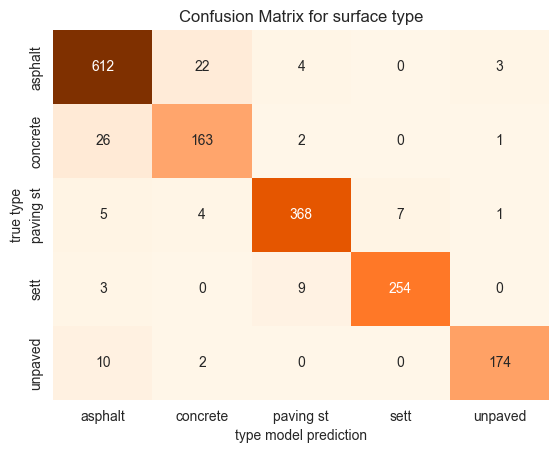

In [63]:
# validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])
cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

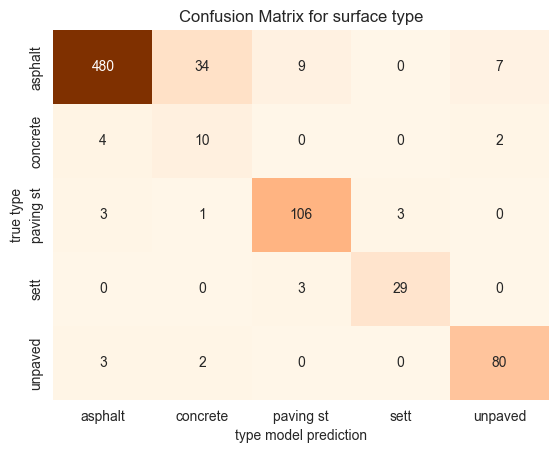

In [64]:
# test
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])
cm = confusion_matrix(df_test_type.type_true, df_test_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

## Measures for quality by surface type

In [65]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,unpaved,paving_stones,sett
accuracy,0.62,0.82,0.65,0.59,0.70
correlation,0.80,0.91,0.74,0.68,0.66
r_square,0.58,0.80,0.52,0.37,0.37
mse,0.32,0.16,0.30,0.36,0.24
rmse,0.56,0.40,0.55,0.60,0.49


In [66]:
gm_surface = pd.DataFrame()
for surface in df_test_quality.type_true.unique():
    df_ = df_test_quality[df_test_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,unpaved,asphalt,sett,paving_stones,concrete
accuracy,0.64,0.62,0.62,0.65,0.60
correlation,0.65,0.62,0.68,0.46,0.80
r_square,0.20,0.30,0.07,0.05,0.64
mse,0.33,0.31,0.29,0.28,0.20
rmse,0.57,0.55,0.54,0.53,0.45


## compare float values

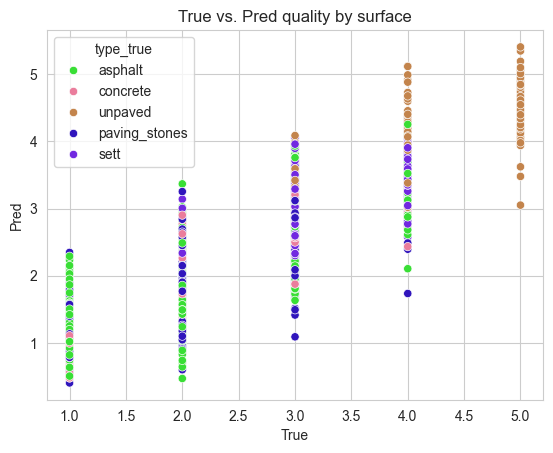

In [67]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


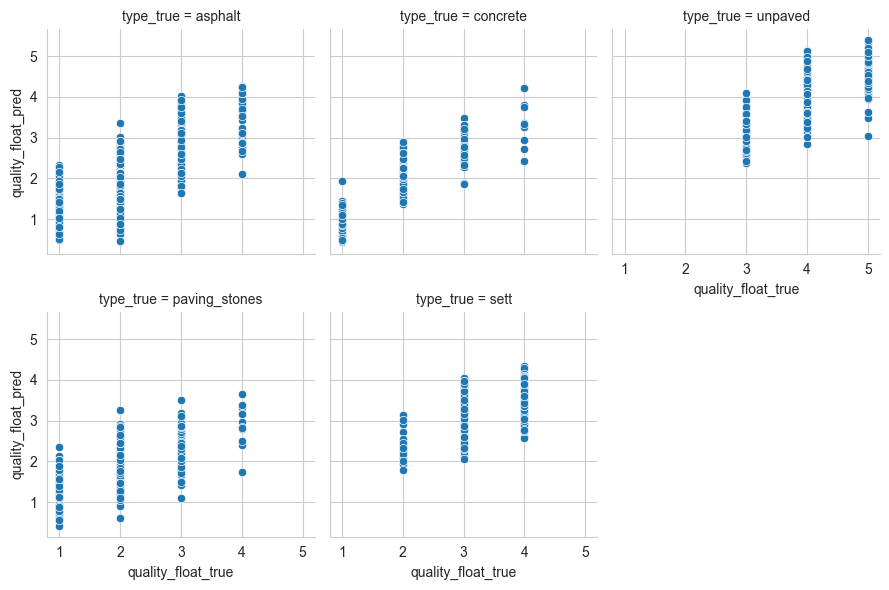

In [68]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [70]:
dev = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred
df_valid_quality.loc[:,"deviation"] = dev

**Overall**

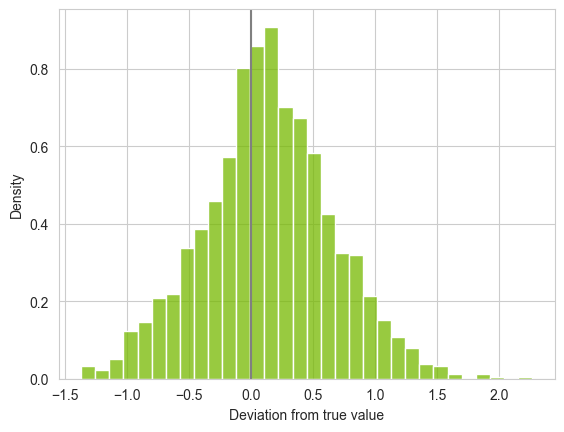

In [71]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [72]:
np.mean(df_valid_quality.deviation)

0.1361384907017689

In [73]:
np.std(df_valid_quality.deviation)


0.5272600274534639

In [74]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1464
True      107
Name: count, dtype: int64

In [75]:
sum(abs(df_valid_quality.deviation) >= 1)/len(df_valid_quality)

0.06810948440483769

**by surface**

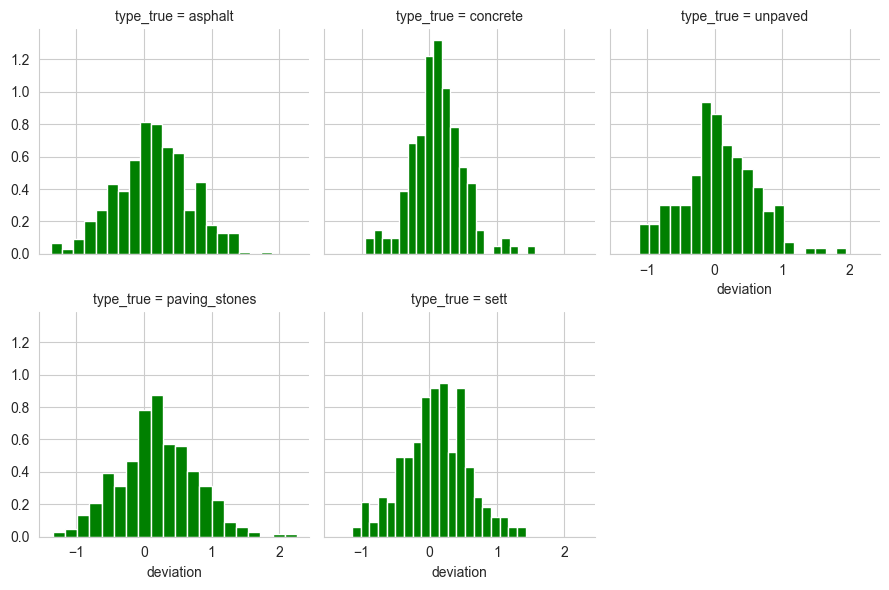

In [76]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

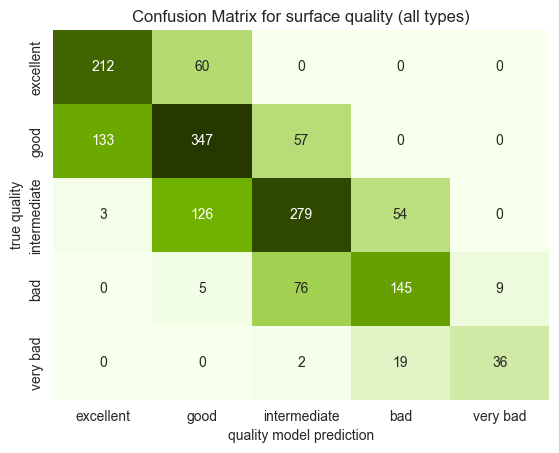

In [77]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_label_true, df_valid_quality.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

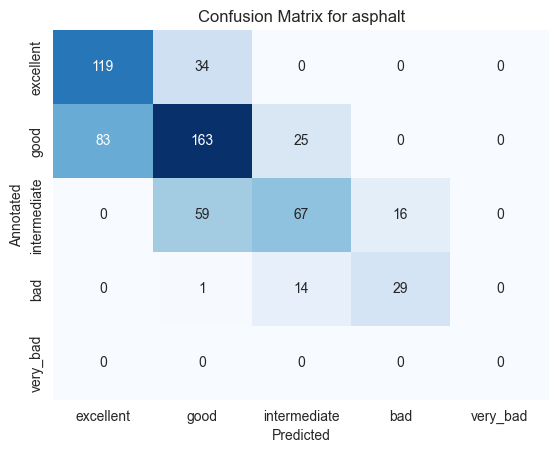

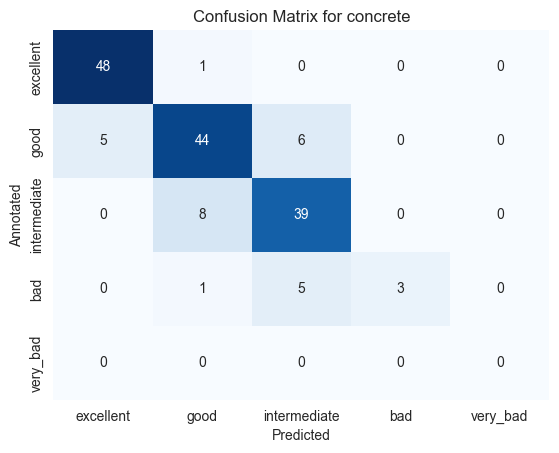

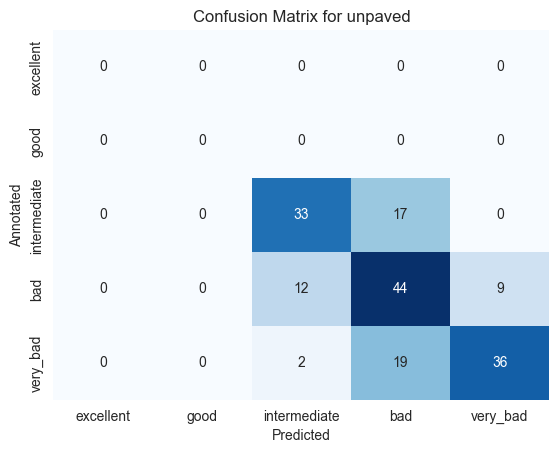

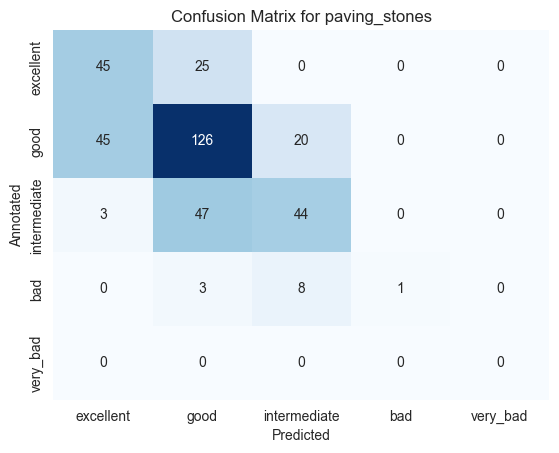

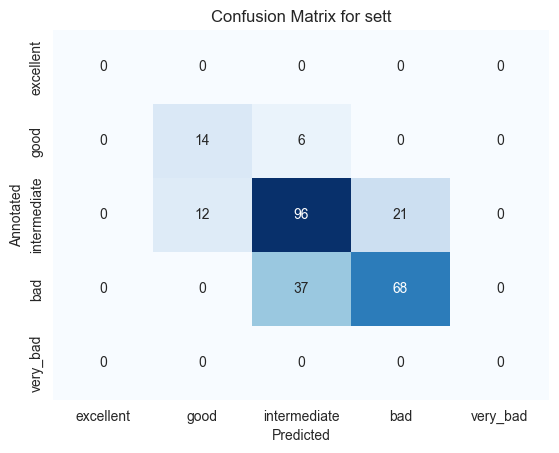

In [78]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [79]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 656
Count (true): 641
Precision: 0.93
Recall: 0.95
------------------------
Class: concrete
Count (pred): 191
Count (true): 192
Precision: 0.85
Recall: 0.85
------------------------
Class: unpaved
Count (pred): 179
Count (true): 186
Precision: 0.97
Recall: 0.94
------------------------
Class: paving_stones
Count (pred): 383
Count (true): 385
Precision: 0.96
Recall: 0.96
------------------------
Class: sett
Count (pred): 261
Count (true): 266
Precision: 0.97
Recall: 0.95
------------------------
------------------------
------------------------
Average precision: 0.94
Average recall: 0.93
Average F1-Score: 0.93
Accuracy: 0.94
